In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm

import mltools.utils.cuda_tools as cuda_tools
device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import importlib
importlib.reload(utils)

memory_available [69511]
best GPU: 0


<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/notebooks/../utils.py'>

In [2]:
os.chdir('/n/home12/cfpark00/ML/ToyCompDiff')

In [57]:
plot_datas=[]
acc_sigma=5
s=0.1
fixed_acc=s*3
ignore_nuisance=True
det_model=False#True#False#
#for fol in glob.glob("./data/2x2/base/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.001/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.003/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.01/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.03/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.1/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/base/dim=3_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.001/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.003/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.01/dim=2_seed=*"):
#for fol in glob.glob("./data/2x2/s=0.03/dim=3_seed=*"):
for fol in glob.glob("./data/2x2/s=0.1/dim=3_seed=*"):
    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)

    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)
    n_classes=len(config["means"])
    #losses
    loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
    if det_model:
        losses_perclass={l:[] for l in range(n_classes)}
    else:
        loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
        losses_perclass={l:dict(zip(loss_keys,[[] for _ in range(len(loss_keys))])) for l in range(n_classes)}
    ckpts=[]
    gens_tr=[]
    gens_te=[]
    model=utils.get_model(config)
    for ckpt_path in tqdm.tqdm(logs["ckpt_paths"]):
        if "h64" in fol:
            print("For h64, changing ckpt path")
            ckpt_path=ckpt_path.replace("/base/","/h64/base/")
        ckpt=torch.load(ckpt_path)
        if not det_model:
            for key in list(ckpt.keys()):
                if key[:4]=="net.":
                    del ckpt[key]
        ckpts.append(ckpt)
        model.load_state_dict(ckpt)
        model=model.to(device)
        x_tr_torch=torch.tensor(x_tr).to(device=device,dtype=torch.float32)
        y_tr_torch=torch.tensor(y_tr).to(device=device,dtype=torch.float32)
        x_te_torch=torch.tensor(x_te).to(device=device,dtype=torch.float32)
        y_te_torch=torch.tensor(y_te).to(device=device,dtype=torch.float32)
        ##loss
        with torch.no_grad():
            if det_model:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none").mean(-1)
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none").mean(-1)
            else:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none")[1]#decomposed loss
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none")[1]#decomposed loss
        if det_model:
            for l in range(n_classes):
                in_tr=np.any(l_tr==l)
                if in_tr:
                    losses_perclass[l].append(loss_tr[l_tr==l].cpu().numpy())
                else:
                    losses_perclass[l].append(loss_te[l_te==l].cpu().numpy())
        else:
            for loss_key in loss_keys:
                for l in range(n_classes):
                    in_tr=np.any(l_tr==l)
                    if in_tr:
                        losses_perclass[l][loss_key].append(loss_tr[loss_key][l_tr==l].cpu().numpy())
                    else:
                        losses_perclass[l][loss_key].append(loss_te[loss_key][l_te==l].cpu().numpy())
        ##
        with torch.no_grad():
            gen_tr=model.generate(y_tr_torch).detach().cpu().numpy()
            gen_te=model.generate(y_te_torch).detach().cpu().numpy()
        gens_tr.append(gen_tr)
        gens_te.append(gen_te)
    if det_model:
        for l in range(n_classes):
            losses_perclass[l]=np.stack(losses_perclass[l],axis=0)
    else:
        for l in range(n_classes):
            for loss_key in loss_keys:
                losses_perclass[l][loss_key]=np.stack(losses_perclass[l][loss_key],axis=0)

    gens_tr=np.stack(gens_tr,axis=0)
    gens_te=np.stack(gens_te,axis=0)

    save_steps=logs["save_steps"]
    losses=np.array(logs["losses"])
    val_losses=np.array(logs["val_losses"])
    te_losses=np.array(logs["te_losses"])

    means=np.array(config["means"])
    covs=np.array(config["covs"])
    if not ignore_nuisance:
        if "dim_nuisance" in config:
            if "nl_nuisance" in config and config["nl_nuisance"]:
                assert False
            else:
                n,d,dn=means.shape[0],means.shape[1],config["dim_nuisance"]
                nuisance_scale=config.get("nuisance_scale",1.0)
                means=np.concatenate([means,np.zeros((n,dn))],axis=1)
                nuisance_cov=(np.eye(dn)*nuisance_scale**2)[None,:,:].repeat(n,axis=0)
                covs_=np.zeros((n,d+dn,d+dn))
                covs_[:,:d,:d]=covs
                covs_[:,d:,d:]=nuisance_cov
                covs=covs_
                dim=d+dn
        invcovs=np.stack([np.linalg.inv(cov) for cov in covs],axis=0)
        means_sqdist_tr=np.power( (gens_tr-means[l_tr]).mean(1),2 ).mean(1)
        means_sqdist_te=np.power( (gens_te-means[l_te]).mean(1),2 ).mean(1)
    else:
        dim=means.shape[1]
        invcovs=np.stack([np.linalg.inv(cov) for cov in covs],axis=0)
        means_sqdist_tr=np.power( (gens_tr[:,:,:dim]-means[l_tr]).mean(1),2 ).mean(1)
        means_sqdist_te=np.power( (gens_te[:,:,:dim]-means[l_te]).mean(1),2 ).mean(1)

    means_sqdist_perclass={}
    for l in range(n_classes):
        in_tr=np.any(l_tr==l)
        if in_tr:
            means_sqdist_perclass[l]=np.power( (gens_tr[:,l_tr==l,:dim]-means[l]).mean(1),2 ).mean(1)
        else:
            means_sqdist_perclass[l]=np.power( (gens_te[:,l_te==l,:dim]-means[l]).mean(1),2 ).mean(1)

    dev_tr=gens_tr[:,:,:dim]-means[l_tr]
    dev_te=gens_te[:,:,:dim]-means[l_te]
    if fixed_acc is not None:
        d_tr=np.linalg.norm(dev_tr,axis=-1)
        d_te=np.linalg.norm(dev_te,axis=-1)
        accs_tr=(d_tr<=fixed_acc).astype(np.float32).mean(-1)
        accs_te=(d_te<=fixed_acc).astype(np.float32).mean(-1)
    else:
        z_tr=np.einsum("tbi,bij,tbj->tb",dev_tr,invcovs[l_tr],dev_tr)/means.shape[-1]
        z_te=np.einsum("tbi,bij,tbj->tb",dev_te,invcovs[l_te],dev_te)/means.shape[-1]
        accs_tr=(z_tr<acc_sigma).astype(np.float32).mean(-1)
        accs_te=(z_te<acc_sigma).astype(np.float32).mean(-1)
    accs_perclass={}
    for l in range(n_classes):
        in_tr=np.any(l_tr==l)
        if in_tr:
            if fixed_acc is not None:
                accs_perclass[l]=(d_tr[:,l_tr==l]<=fixed_acc).astype(np.float32).mean(-1)
            else:
                accs_perclass[l]=(z_tr[:,l_tr==l]<acc_sigma).astype(np.float32).mean(-1)
        else:
            if fixed_acc is not None:
                accs_perclass[l]=(d_te[:,l_te==l]<=fixed_acc).astype(np.float32).mean(-1)
            else:
                accs_perclass[l]=(z_te[:,l_te==l]<acc_sigma).astype(np.float32).mean(-1)

    plot_data={}
    plot_data["gens_tr"]=gens_tr
    plot_data["gens_te"]=gens_te
    plot_data["min_vlb"]=model.get_min_vlb() if hasattr(model,"get_min_vlb") else 0
    plot_data["save_steps"]=save_steps
    plot_data["losses"]=losses
    plot_data["val_losses"]=val_losses
    plot_data["te_losses"]=te_losses
    plot_data["means_sqdist_tr"]=means_sqdist_tr
    plot_data["means_sqdist_te"]=means_sqdist_te
    plot_data["means_sqdist_perclass"]=means_sqdist_perclass
    plot_data["losses_perclass"]=losses_perclass
    plot_data["accs_perclass"]=accs_perclass
    plot_data["accs_tr"]=accs_tr
    plot_data["accs_te"]=accs_te
    plot_data["ckpts"]=ckpts
    plot_datas.append(plot_data)

100%|██████████| 60/60 [00:07<00:00,  7.97it/s]


In [58]:
n_classes=config["n_classes"]
tri=np.nonzero(config["n_samples_train"])[0]

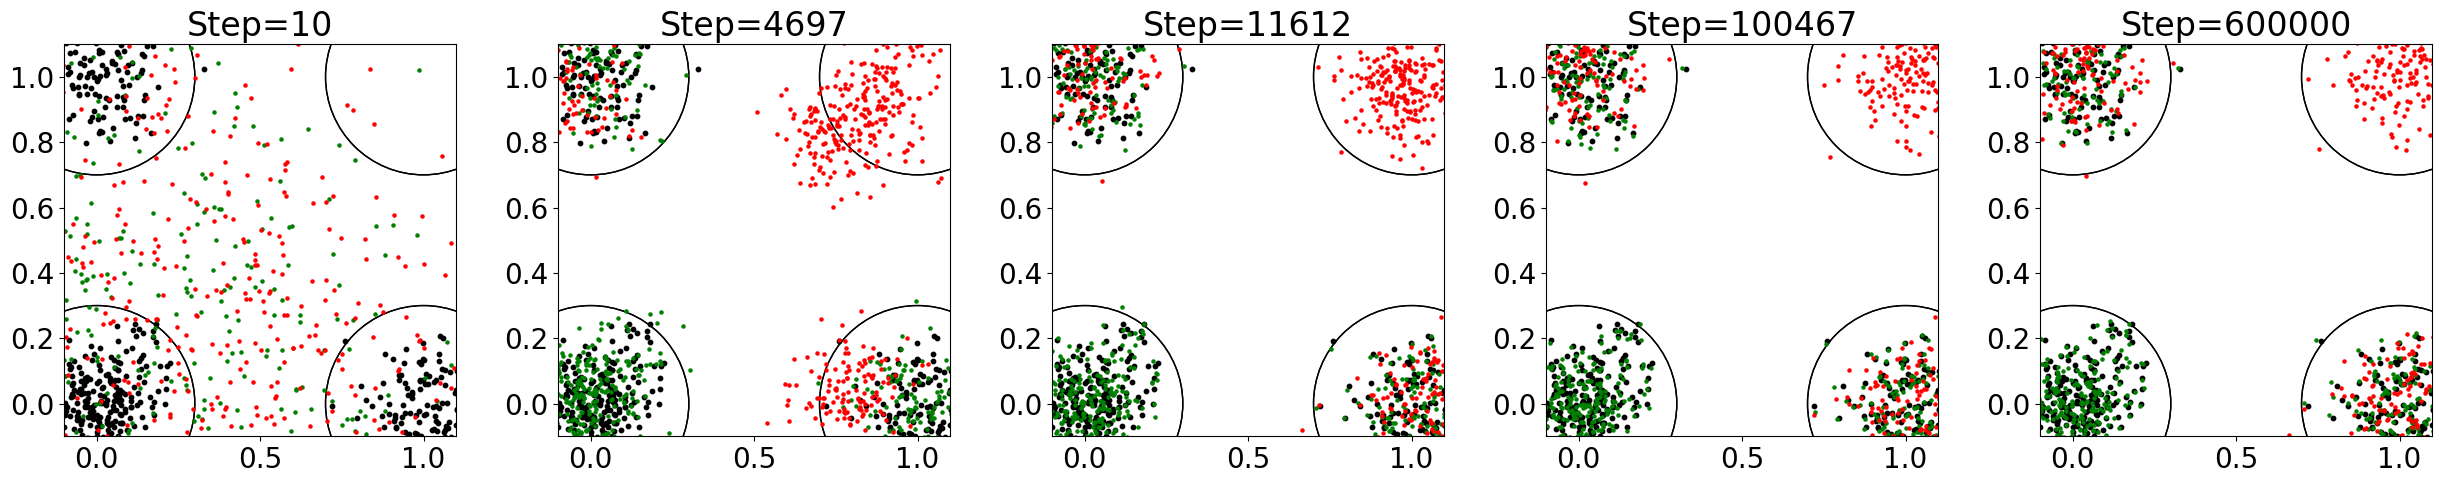

In [59]:
import matplotlib
cmap=plt.get_cmap("coolwarm")
plt.figure(figsize=(25,5))
plt.rcParams.update({'font.size': 20})
c=0
for i in [0,5,8,24,59]:
    plt.subplot(1,5,c+1)
    plt.scatter(x_tr[:,0],x_tr[:,1],c="black",s=10)
    #draw circles
    means=np.array(config["means"])
    #plt.plot(means[:,0],means[:,1],c="black",ms=35,marker="o",mfc='none',ls="None")
    for loc in means:
        circle=plt.Circle((loc[0],loc[1]), color="black",radius=fixed_acc,fill=False)
        plt.gca().add_artist(circle)
    #coll = matplotlib.collections.PatchCollection(circles)
    #plt.gca().add_collection(coll)

    plt.scatter(gens_tr[i,:,0],gens_tr[i,:,1],s=5,c="g")
    plt.scatter(gens_te[i,:,0],gens_te[i,:,1],s=5,c="r")
    plt.title(f"Step={save_steps[i]}")
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.gca().set_aspect('equal')
    c+=1
plt.tight_layout()
#plt.savefig("./figures/training_progress.png")

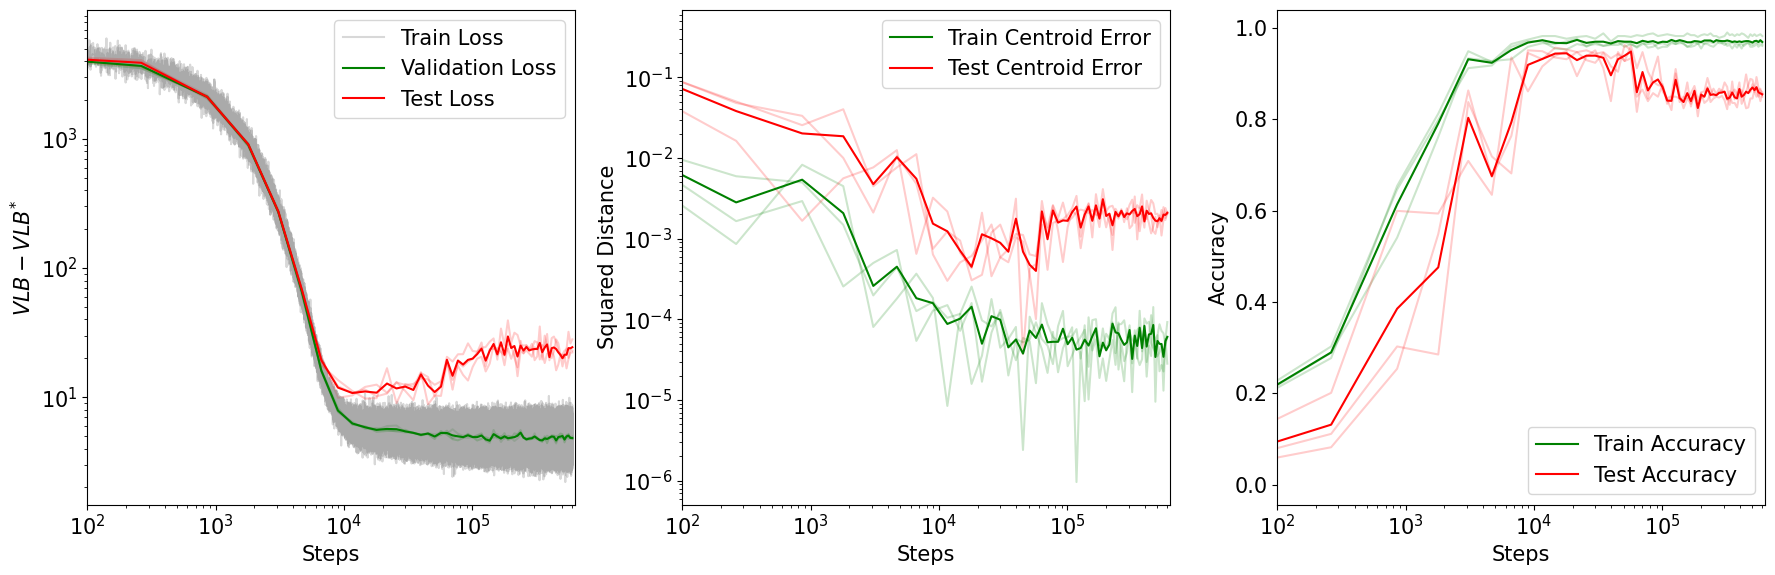

In [60]:
x_left=100

plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,3,1)
val_lossess=[]
te_lossess=[]
for i,plot_data in enumerate(plot_datas):
    min_vlb=plot_data["min_vlb"]
    save_steps=plot_data["save_steps"]
    losses=plot_data["losses"]
    val_losses=plot_data["val_losses"]
    val_lossess.append(val_losses)
    te_losses=plot_data["te_losses"]
    te_lossess.append(te_losses)
    plt.plot(losses-min_vlb,c="gray",alpha=0.3,label="Train Loss" if i==0 else None)
    plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.2)
    plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.2)
val_lossess=np.stack(val_lossess,axis=0)
te_lossess=np.stack(te_lossess,axis=0)
vl_m=val_lossess.mean(0)
tl_m=te_lossess.mean(0)
plt.plot(save_steps,vl_m-min_vlb,label="Validation Loss",c="green")
plt.plot(save_steps,tl_m-min_vlb,label="Test Loss",c="red")
plt.xlim(left=x_left)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel(r"$VLB-VLB^{*}$")
plt.legend()

plt.subplot(1,3,2)
means_sqdist_trs=[]
means_sqdist_tes=[]
for i,plot_data in enumerate(plot_datas):
    means_sqdist_tr=plot_data["means_sqdist_tr"]
    means_sqdist_te=plot_data["means_sqdist_te"]
    means_sqdist_trs.append(means_sqdist_tr)
    means_sqdist_tes.append(means_sqdist_te)
    plt.plot(save_steps,means_sqdist_tr,c="green",alpha=0.2)
    plt.plot(save_steps,means_sqdist_te,c="red",alpha=0.2)
means_sqdist_trs=np.stack(means_sqdist_trs,axis=0)
means_sqdist_tes=np.stack(means_sqdist_tes,axis=0)
mdtr_m=means_sqdist_trs.mean(0)
mdte_m=means_sqdist_tes.mean(0)
plt.plot(save_steps,mdtr_m,label="Train Centroid Error",c="green")
plt.plot(save_steps,mdte_m,label="Test Centroid Error",c="red")
plt.xlim(left=x_left)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Squared Distance")
plt.legend()

plt.subplot(1,3,3)
accs_trs=[]
accs_tes=[]
for i,plot_data in enumerate(plot_datas):
    accs_tr=plot_data["accs_tr"]
    
    accs_te=plot_data["accs_te"]
    accs_trs.append(accs_tr)
    accs_tes.append(accs_te)
    plt.plot(save_steps,accs_tr,c="green",alpha=0.2)
    plt.plot(save_steps,accs_te,c="red",alpha=0.2)
accs_trs=np.stack(accs_trs,axis=0)
accs_tes=np.stack(accs_tes,axis=0)
acctr_m=accs_trs.mean(0)
accte_m=accs_tes.mean(0)
plt.plot(save_steps,acctr_m,label="Train Accuracy",c="green")
plt.plot(save_steps,accte_m,label="Test Accuracy",c="red")
plt.xlim(left=x_left)
plt.xscale("log")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

#plt.savefig("./figures/2x2/3d_s=0.1.png")

In [75]:
import scipy.stats as sstats
r_crit=(sstats.chi2(df=1).ppf(0.997))**(1/2)
r_crit

2.9677379253417824

In [84]:
wds=["0.0025","0.005","0.01","0.02","0.04"]
ss=["0.01","0.03","0.05","0.07","0.09"]
dim=3

all_data={}
for fol in tqdm.tqdm(glob.glob(f"./data/2x2/wd*_s*/dim={dim}_seed=*")):
    supfol_name=os.path.basename(os.path.dirname(fol))
    wd=supfol_name.split("_")[0].replace("wd=","")
    s=supfol_name.split("_")[1].replace("s=","")
    config=utils.load_config(glob.glob(os.path.join(fol,"*.yaml"))[0])
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)
    losses=np.array(logs["losses"])
    save_steps=np.array(logs["save_steps"])
    val_losses=np.array(logs["val_losses"])
    te_losses=np.array(logs["te_losses"])
    min_vlb=logs["min_vlb"]

    thres=0.1
    generation_fol=os.path.join(fol,"generations")
    generation_paths=glob.glob(os.path.join(generation_fol,"*.pth"))
    def sortkey(path):
        return int(os.path.basename(path).split("_")[1].split(".")[0])
    generation_paths.sort(key=sortkey)
    accs_tr=[]
    accs_te=[]
    means=np.array(config["means"])
    for generation_path in generation_paths:
        generation=torch.load(generation_path)
        gen_tr=generation["gen_tr"][:,:dim]
        gen_te=generation["gen_te"][:,:dim]
        y_tr=generation["y_tr_gen"]
        y_te=generation["y_te_gen"]
        l_tr=generation["l_tr_gen"]
        l_te=generation["l_te_gen"]
        #tr_dev=gen_tr-means[l_tr]
        #te_dev=gen_te-means[l_te]
        tr_dev=gen_tr-y_tr#[l_tr]
        te_dev=gen_te-y_te#[l_te]
        acc_tr=np.linalg.norm(tr_dev,axis=-1)<=thres
        acc_te=np.linalg.norm(te_dev,axis=-1)<=thres
        accs_tr.append(acc_tr.mean())
        accs_te.append(acc_te.mean())
    accs_tr=np.array(accs_tr)
    accs_te=np.array(accs_te)
    #print(accs_tr.shape,accs_te.shape)
    #assert False

    all_data.setdefault((wd,s),{}).setdefault("losses",[]).append(losses)
    all_data.setdefault((wd,s),{}).setdefault("val_losses",[]).append(val_losses)
    all_data.setdefault((wd,s),{}).setdefault("te_losses",[]).append(te_losses)
    all_data.setdefault((wd,s),{}).setdefault("save_steps",[]).append(save_steps)
    all_data.setdefault((wd,s),{}).setdefault("accs_tr",[]).append(accs_tr)
    all_data.setdefault((wd,s),{}).setdefault("accs_te",[]).append(accs_te)

100%|██████████| 75/75 [00:09<00:00,  7.51it/s]


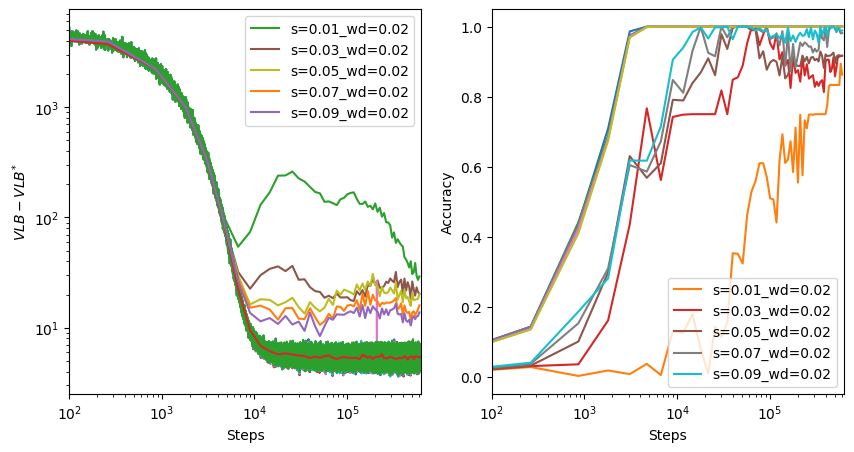

In [90]:
s="0.05"
wd="0.02"
x_left=100

plt.figure(figsize=(10,5))
ax1,ax2=plt.subplot(1,2,1),plt.subplot(1,2,2)
#for wd in wds:
for s in ss:
    lossdict=all_data[(wd,s)]
    save_steps=np.array(lossdict["save_steps"][0])
    losses=np.array(lossdict["losses"])
    val_losses=np.array(lossdict["val_losses"])
    te_losses=np.array(lossdict["te_losses"])
    accs_tr=np.array(lossdict["accs_tr"])
    accs_te=np.array(lossdict["accs_te"])

    ax1.plot(losses.mean(0)-min_vlb)
    ax1.plot(save_steps,val_losses.mean(0)-min_vlb)
    ax1.plot(save_steps,te_losses.mean(0)-min_vlb,label=f"s={s}_wd={wd}")

    ax2.plot(save_steps,accs_tr.mean(0))
    ax2.plot(save_steps,accs_te.mean(0),label=f"s={s}_wd={wd}")


ax1.set_xlim(left=x_left)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Steps")
ax1.set_ylabel(r"$VLB-VLB^{*}$")
ax1.legend()

ax2.set_xlim(left=x_left)
ax2.set_xscale("log")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy")
ax2.legend()

In [80]:
len(all_losses[(wds[0],ss[0])])

3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


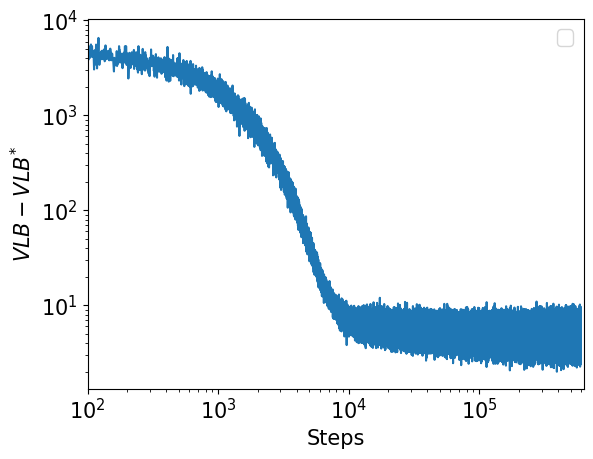

In [74]:
plt.plot(losses-min_vlb)

plt.xlim(left=x_left)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel(r"$VLB-VLB^{*}$")
plt.legend()
